# Première implementation des modèles

Ce notebook est fait pour faire des tests sur l'implémentation des modèles, de la génération des données, des graphiques, etc.

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/mbenj/smc_movement_models


In [2]:
import statsmodels
import statsmodels.api as sm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nprd
import pandas as pd

from smc_movement_models.plots import plot_graph_values, plot_real_data

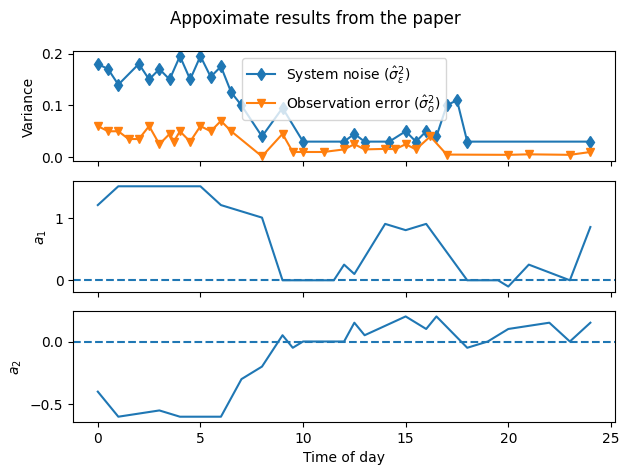

In [4]:
gv_fig = plot_graph_values(figsize=None)

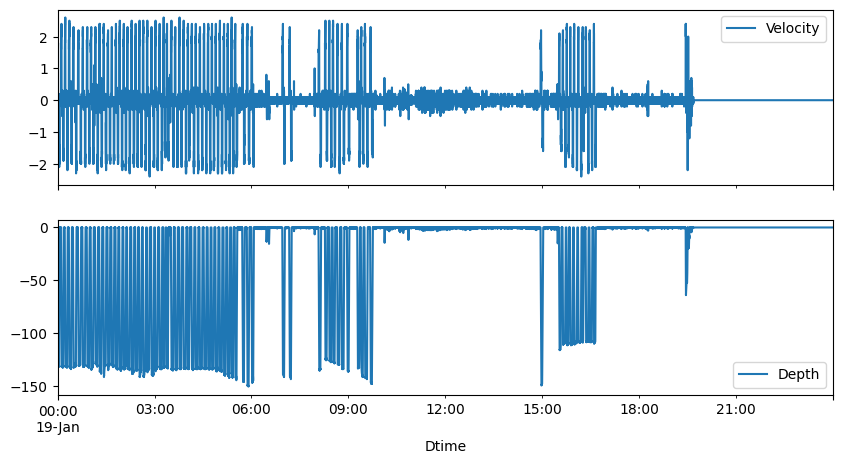

In [5]:
day_fig = plot_real_data("/home/mbenj/smc_movement_models/data/19_01_2008.csv", figsize=(10, 5))

In [6]:
day = pd.read_csv("/home/mbenj/smc_movement_models/data/19_01_2008.csv", parse_dates=[0])

In [7]:
day.head()

,Dtime,Velocity,Depth
0,2008-01-19 00:00:00,-0.1,-130.5
1,2008-01-19 00:00:05,0.4,-132.5
2,2008-01-19 00:00:10,-0.2,-131.5
3,2008-01-19 00:00:15,0.0,-131.5
4,2008-01-19 00:00:20,0.1,-132.0


In [8]:
import numpy as np
import particles
import particles.distributions as dists
import particles.state_space_models as ssms
from particles.distributions import Gamma, IndepProd, Normal

from smc_movement_models.models import MarineSSM

In [33]:
window = day[:312]["Velocity"]
my_ssm_model = MarineSSM(z0=window[0], z1=window[1])
my_fk_model = ssms.Bootstrap(ssm=my_ssm_model, data=window)

In [34]:
my_alg = particles.SMC(fk=my_fk_model, N=100, store_history = True)
a1s = []
a2s = []
my_alg.run()
a1s = my_alg.hist.X[-1][:,2]
a2s = my_alg.hist.X[-1][:,3]

In [67]:
def run_smc(window, N=100, **kwargs):
    my_ssm_model = MarineSSM(z0=window[0], z1=window[1], **kwargs)
    my_fk_model = ssms.Bootstrap(ssm=my_ssm_model, data=window)
    my_alg = particles.SMC(fk=my_fk_model, N=N, store_history = True)
    my_alg.run()
    
    return np.asarray([np.dot(my_alg.hist.wgts[i].W,my_alg.hist.X[-1][:,2:]) for i in range(len(window))])

In [94]:
def one_estimate(ploty = False):
    epsilon = 0.1
    final_a1s = [0]
    final_a2s = [0]
    if ploty:
        x_range = np.arange(len(window))
        fig, axs = plt.subplots(2, 1, figsize=(10, 5))
    for m in range(10):
        a = run_smc(window=window, sigma_v=epsilon, a1=final_a1s[-1], a2=final_a2s[-1])
        a1s, a2s = a[:,0], a[:,1]
        final_a1s.append(a1s.mean())
        final_a2s.append(a2s.mean())
        epsilon *= 0.5
        if ploty:
            axs[0].plot(x_range, a1s, label = m)
            axs[1].plot(x_range, a2s, label = m)
            axs[0].legend()
            axs[1].legend()
    return a1s, a2s

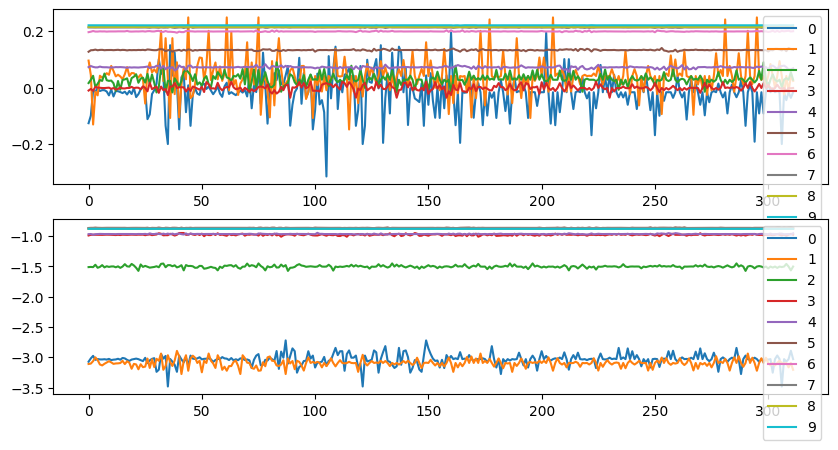

In [95]:
final_a1s = []
final_a2s = []
a1s, a2s = one_estimate(ploty = True)


In [96]:
final_a1s = []
final_a2s = []
for i in range(100):
    a1s, a2s = one_estimate()
    if np.isnan(a1s).all():
        pass
    else:
        final_a1s.append(a1s)
        final_a2s.append(a2s)

In [97]:
final_a1s = np.asarray(final_a1s)
final_a2s = np.asarray(final_a2s)

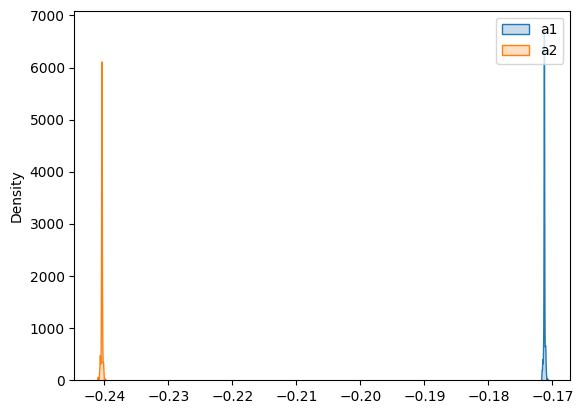

In [98]:
import seaborn as sns

sns.kdeplot(final_a1s[-1], fill=True, label="a1")
sns.kdeplot(final_a2s[-1], fill=True, label="a2")
plt.legend()

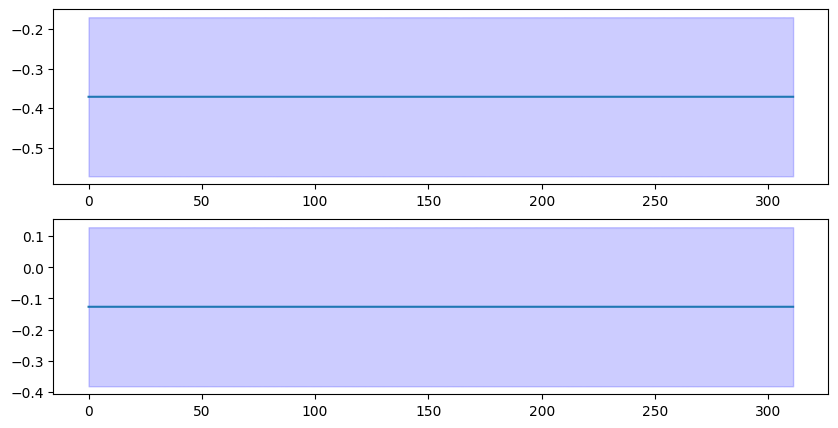

In [104]:
x_range = np.arange(len(window))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(x_range, final_a1s.mean(axis = 0))
axs[0].fill_between(x_range, final_a1s.mean(axis = 0) - np.var(final_a1s, axis = 0), final_a1s.mean(axis = 0) + np.var(final_a1s, axis = 0), color='blue', alpha=0.2)
axs[1].plot(x_range, final_a2s.mean(axis = 0))
axs[1].fill_between(x_range, final_a2s.mean(axis = 0) - np.var(final_a2s, axis = 0), final_a2s.mean(axis = 0) + np.var(final_a2s, axis = 0), color='blue', alpha=0.2)

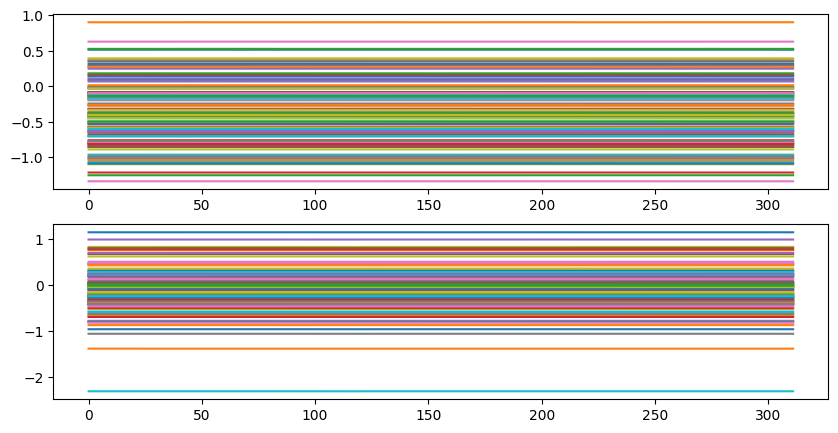

In [105]:
x_range = np.arange(len(window))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
for i in range(100):
    axs[0].plot(x_range, final_a1s[i])
    axs[1].plot(x_range, final_a2s[i])

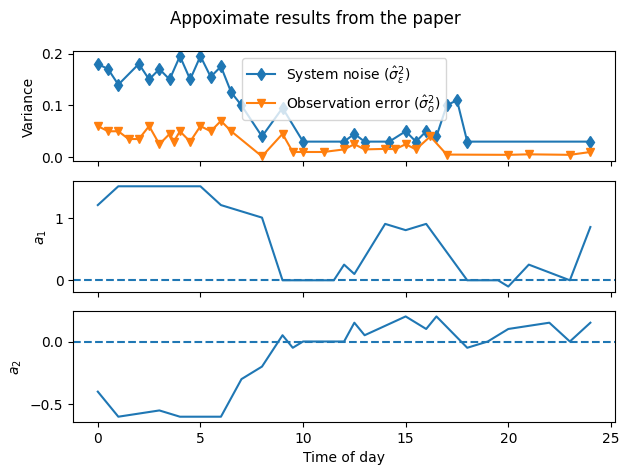

In [101]:
gv_fig = plot_graph_values(figsize=None)